# Predict weather
For renewable generation, predict:
- Irradiance (GHI)
- Temperature
- Wind speed

In [17]:
!pip install darts
#!pip install pandas
#!pip install numpy
#!pip install plotly

!pip install pyyaml #==5.4.1 # Google colab

#GPU: https://unit8co.github.io/darts/userguide/gpu_and_tpu_usage.html

#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
#!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
#!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.22.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


In [3]:
import darts as dts
import pandas as pd
import numpy as np
import plotly.express as px

In [4]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
#from darts import concatenate

In [5]:
N_DAY = 24*4 #number of measures in a day
N_HOURS = 23 # from 0 to 23 hour in day
N_MINS = 45 # from 0 to 45 min in hour
N_PRED = int(N_DAY * 1.5)

In [6]:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=c2W5A2px3doP
from google.colab import drive
drive.mount('/content/drive')

df2017 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/361685_47.41_0.78_2017.csv', skiprows=2)
df2018 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/361685_47.41_0.78_2018.csv', skiprows=2)
df2019 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/361685_47.41_0.78_2019.csv', skiprows=2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# df = pd.read_csv('dataset1_tropical.csv', sep=";")
#df['datetime'] = pd.to_datetime(df['datetime'])

# load data
#df2017 = pd.read_csv('data/361685_47.41_0.78_2017.csv', skiprows=2)
#df2018 = pd.read_csv('data/361685_47.41_0.78_2018.csv', skiprows=2)
#df2019 = pd.read_csv('data/361685_47.41_0.78_2019.csv', skiprows=2)

#concatenate in a whole dataset
df = pd.concat([df2017, df2018, df2019])

#genenarate a datetime index column
df['datetime'] = pd.to_datetime(df['Year'].astype(str) +'-' 
                                + df['Month'].astype(str) 
                                + '-' + df['Day'].astype(str) 
                                + ' ' + df['Hour'].astype(str) 
                                + ':' + df['Minute'].astype(str) + ':00'
                                )

#set datetiem as index
df = df.set_index('datetime')

#drop useless columns
df = df.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1)

# accelerate processing by reducing information
#df = df.astype(np.float32)

In [8]:
df.info()
# df.isnull().sum()  # missing value

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105120 entries, 2017-01-01 00:00:00 to 2019-12-31 23:45:00
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Temperature         105120 non-null  float64
 1   GHI                 105120 non-null  int64  
 2   Relative Humidity   105120 non-null  float64
 3   Pressure            105120 non-null  int64  
 4   Precipitable Water  105120 non-null  float64
 5   Wind Direction      105120 non-null  int64  
 6   Wind Speed          105120 non-null  float64
 7   Dew Point           105120 non-null  float64
 8   Cloud Type          105120 non-null  int64  
 9   Fill Flag           105120 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 8.8 MB


In [ ]:
frequency = pd.Timedelta('1 day')
df_resampled = df.resample(frequency).mean()
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Freq: D
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature         1095 non-null   float64
 1   GHI                 1095 non-null   float64
 2   Relative Humidity   1095 non-null   float64
 3   Pressure            1095 non-null   float64
 4   Precipitable Water  1095 non-null   float64
 5   Wind Direction      1095 non-null   float64
 6   Wind Speed          1095 non-null   float64
 7   Dew Point           1095 non-null   float64
 8   Cloud Type          1095 non-null   float64
 9   Fill Flag           1095 non-null   float64
dtypes: float64(10)
memory usage: 94.1 KB


In [ ]:
fig = px.imshow(df_resampled.corr())
fig.show()

In [ ]:
fig = px.imshow(df.between_time('9:00','17:00').corr())
fig.show()

In [ ]:
fig = px.line(df_resampled.loc['2017-1-1':'2017-12-31'])
fig.show()

In [ ]:
fig = px.line(df_resampled['GHI'].diff())
fig.show()

In [ ]:
fig = px.line(y=[df['GHI'], df['GHI'].rolling(window=4).mean()])
fig.show()

In [9]:
# extract explainable variables
series_ghi = dts.timeseries.TimeSeries.from_series(df['GHI'])
#series_pressure = dts.timeseries.TimeSeries.from_series(df['Pressure'])
#series_water = dts.timeseries.TimeSeries.from_series(df['Precipitable Water'])
#series_wddir= dts.timeseries.TimeSeries.from_series(df['Wind Direction'])
series_wdspeed = dts.timeseries.TimeSeries.from_series(df['Wind Speed'])

In [10]:
# normalize to use deep learning
from darts.dataprocessing.transformers import Scaler
scaler_ghi, scaler_wdspeed = Scaler(), Scaler()
# series_scaled
series_s_ghi = scaler_ghi.fit_transform(series_ghi)
series_s_wdspeed = scaler_wdspeed.fit_transform(series_wdspeed)

# to inverse scaled with
# scaler_ghi.inverse_transform(series_s_ghi).plot()

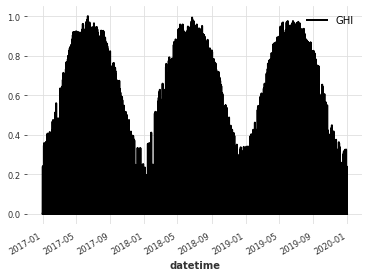

In [ ]:
series_s_ghi.plot()

In [ ]:
#fig = px.line(series_s_ghi.pd_dataframe())
#fig.show()

In [11]:
# set covariate

# covariate for renewable generation
renew_covs = dts.concatenate(
    [
        # df.index.month,
        dt_attr(df.index, "month", dtype=np.float32) / 12,  # month for seasons
        dt_attr(df.index, "hour", dtype=np.float32) / 23,  # hours for sun light
        #series_s_wdspeed,
    ],
    axis="component",
)

# covariation for load consumption
load_covs = dts.concatenate(
    [
        dt_attr(df.index, "month", dtype=np.float32) / 12,  # month for seasons
        dt_attr(df.index, "hour", dtype=np.float32) / 23,  # hours for sun light
        dt_attr(df.index, "dayofweek", dtype=np.float32) / \
        6  # for human consumption
    ],
    axis="component",
)
load_covs = load_covs.add_holidays("FR")  # for human consumption

In [37]:
#test = (dt_attr(df.index, "hour", dtype=np.float32) + dt_attr(df.index, "minute", dtype=np.float32) / N_MINS )/ (23 + 23 / N_MINS)[1:96*4]
#test[1:96*4].plot()

TypeError: ignored

In [15]:
# concatenate a multivariate
multivar_ghi = dts.concatenate([series_s_ghi, series_s_wdspeed], axis=1)

(True, 96)

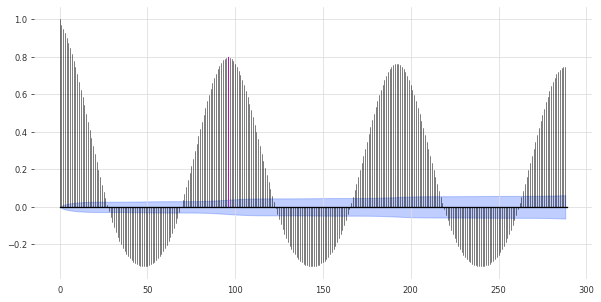

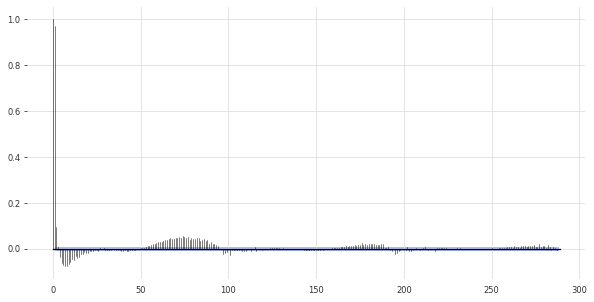

In [19]:
# acf
from darts.utils.statistics import plot_acf, check_seasonality, plot_pacf
plot_acf(series_ghi, m=96, alpha=0.05, max_lag=96*3)
plot_pacf(series_ghi, m=96, alpha=0.05, max_lag=96*3)
check_seasonality(series_ghi, m=96, alpha=0.05, max_lag=96*3)

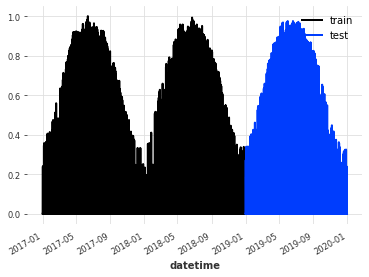

In [38]:
train, test = series_s_ghi.split_before(2./3.)
train.plot(label="train")
test.plot(label="test")

## ARIMA

In [118]:
## ARIMA
#https://towardsdatascience.com/creating-an-arima-model-for-time-series-forecasting-ff3b619b848d

from darts.models.forecasting.arima import ARIMA

model = ARIMA(p=N_DAY)

historical_fcast = model.historical_forecasts(
    series_s_ghi[:10*N_DAY],
    start=0.3,
    forecast_horizon=N_DAY,
    verbose=True,
    #future_covariates=renew_covs,
    #num_samples = 1,
)

  0%|          | 0/578 [00:02<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
series_s_ghi[:10*N_DAY].plot()
historical_fcast.plot()

from darts.metrics import rmse, coefficient_of_variation
rmse(series_s_ghi[:10*N_DAY], historical_fcast)
coefficient_of_variation(series_s_ghi[:10*N_DAY], historical_fcast)

In [119]:
historical_fcast = model.historical_forecasts(
    series_s_ghi[:10*N_DAY],
    start=0.3,
    forecast_horizon=N_DAY,
    verbose=True,
    future_covariates=renew_covs,
    #num_samples = 1,
)

  0%|          | 0/578 [00:07<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
series_s_ghi[:10*N_DAY].plot()
historical_fcast.plot()

from darts.metrics import rmse, coefficient_of_variation
rmse(series_s_ghi[:10*N_DAY], historical_fcast)
coefficient_of_variation(series_s_ghi[:10*N_DAY], historical_fcast)


## ETS
---



In [112]:
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing

model = ExponentialSmoothing(seasonal_periods=N_DAY)

historical_fcast = model.historical_forecasts(
    series_s_ghi[:10*N_DAY],
    start=0.3,
    forecast_horizon=N_DAY,
    #verbose=True
)

 79%|███████▊  | 454/578 [02:48<01:13,  1.69it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

 92%|█████████▏| 530/578 [03:31<00:27,  1.72it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

 92%|█████████▏| 531/578 [03:32<00:28,  1.62it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

 94%|█████████▍| 542/578 [03:38<00:20,  1.72it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

 94%|█████████▍| 543/578 [03:39<00:21,  1.63it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. 

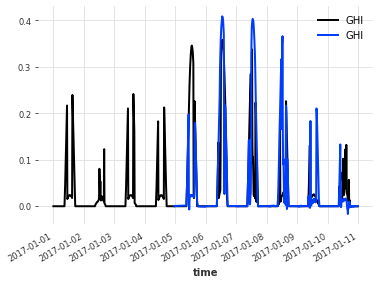

In [115]:
series_s_ghi[:10*N_DAY].plot()
historical_fcast.plot()

In [ ]:
model.fit(series=train[1:N_DAY*2])#,
          # past_covariates=renew_covs)#,
          #future_covariates=renew_covs)

## TFT

In [30]:
#TFT
from darts.models.forecasting.tft_model import TFTModel
#GPU: https://unit8co.github.io/darts/userguide/gpu_and_tpu_usage.html

# create one of Darts' forecasting model
model = TFTModel(input_chunk_length = N_DAY * 7,
                 output_chunk_length = N_DAY,
                  force_reset=True,
                 n_epochs = 50,
                 #pl_trainer_kwargs={
                 #    "accelerator": "gpu",
                 #    "devices": [0]
                 #}
                 )

#historical_fcast = model.historical_forecasts(
#    series_s_ghi[:30*N_DAY],
#    start=0.3,
#    verbose=True,
#    future_covariates=renew_covs,
#    past_covariates=renew_covs,
#    #num_samples = 1,
#    save_checkpoints=True,
#)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [32]:
# fit the model
model.fit(series=train[1:N_DAY*30],
          # past_covariates=renew_covs)#,
          future_covariates=renew_covs,
          #past_covariates=renew_covs,
          
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.8 K 
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [50]:
# make a prediction with the same covariate types
pred = model.predict(n=len(test[:N_DAY*30]),
                     series=test[:N_DAY*31],  # this is only required for GFMs
                     #past_covariates=past_covariates,
                     future_covariates=renew_covs)

Predicting: 66it [00:00, ?it/s]

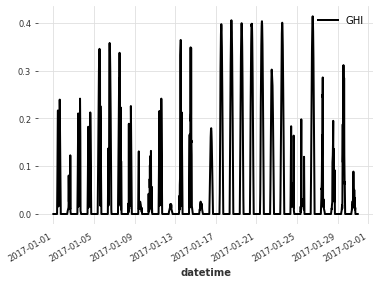

In [44]:
train[: N_DAY*30].plot()

In [53]:
fig = px.line(scaler_ghi.inverse_transform(pred).pd_dataframe())
fig.show()

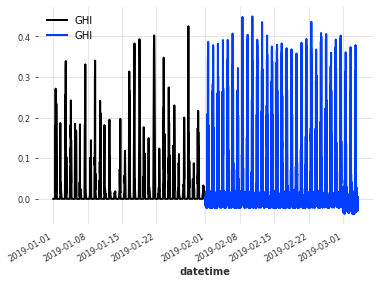

In [51]:
test[:N_DAY*31].plot()
pred.plot()